<a href="https://colab.research.google.com/github/AyushSharma-IN/Deep-Learning-Lab/blob/main/DL_Lab_Exp_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Experiment 3: Neural Network Classification with NumPy

**Objective:** Classify MNIST digits using only NumPy—first with a linear perceptron, then with a multi-layer network with non-linear activation (ReLU).

## 1. Setup and imports

We will use only NumPy for the neural network, plus standard libraries for data loading and plotting. No PyTorch or TensorFlow.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

## 2. Load MNIST

We use the MNIST dataset (handwritten digits 0–9). For simplicity we use a **binary subset** (digits 0 vs 1) so we can do binary classification with a single sigmoid output.

In [2]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, as_frame=False, parser='auto')
X_all, y_all = mnist.data.astype(np.float32), mnist.target.astype(np.int32)
# Build a simple train dataframe format (first col = label, rest = pixels)
train_df = pd.DataFrame(np.hstack([y_all.reshape(-1, 1), X_all]))
train_df.columns = ['label'] + [f'pixel{i}' for i in range(784)]
print('Loaded MNIST from sklearn (fetch_openml).')

Loaded MNIST from sklearn (fetch_openml).


In [3]:
# Use binary subset: digits 0 and 1
CLASS_A, CLASS_B = 0, 1
df = train_df[train_df['label'].isin([CLASS_A, CLASS_B])].copy()
y = df['label'].values
X = df.drop(columns=['label']).values.astype(np.float32)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scale features (fit on train, transform both)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Reshape for consistency: (n, 784)
print('Train shape:', X_train.shape, 'Labels shape:', y_train.shape)
print('Test shape:', X_test.shape, 'Labels shape:', y_test.shape)
print('Class counts (train):', np.bincount(y_train.astype(int)))

Train shape: (11824, 784) Labels shape: (11824,)
Test shape: (2956, 784) Labels shape: (2956,)
Class counts (train): [5522 6302]


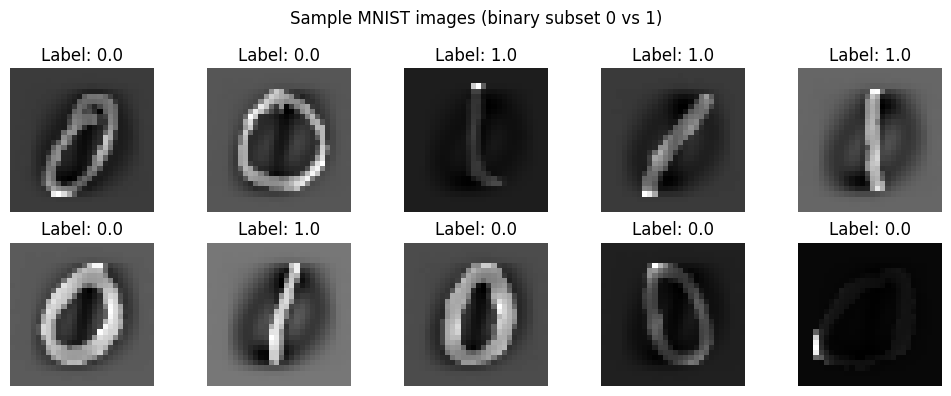

In [4]:
# Show a few sample images
fig, axes = plt.subplots(2, 5, figsize=(10, 4))
for i, ax in enumerate(axes.flat):
    idx = i * (len(X_train) // 10)
    ax.imshow(X_train[idx].reshape(28, 28), cmap='gray')
    ax.set_title(f'Label: {y_train[idx]}')
    ax.axis('off')
plt.suptitle('Sample MNIST images (binary subset 0 vs 1)')
plt.tight_layout()
plt.show()

We have a binary subset of MNIST (0 vs 1) ready. Each image is 28×28 = 784 pixels, scaled to zero mean and unit variance.

## 3. Part A: Single-layer perceptron (linear classifier)

A **perceptron** has one weight matrix **W** and one bias **b**. The output is **sigmoid(W @ x + b)**. This is a **linear classifier** in the 784-dimensional pixel space: it can only learn a single hyperplane (linear decision boundary).

In [5]:
def sigmoid(z):
    return 1 / (1 + np.exp(-np.clip(z, -500, 500)))

def perceptron_forward(X, W, b):
    # X: (n, 784), W: (784, 1), b: (1,) -> out: (n, 1)
    return sigmoid(X @ W + b)

def bce_loss(y_true, y_pred):
    # y_true, y_pred: (n,) or (n, 1). Avoid log(0).
    eps = 1e-15
    y_pred = np.clip(y_pred, eps, 1 - eps)
    return -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))

# Initialize weights: small random values
np.random.seed(42)
input_dim = X_train.shape[1]  # 784
W = np.random.randn(input_dim, 1) * 0.1
b = np.zeros(1)

# Training: gradient descent
lr = 0.1
epochs = 1500
n = X_train.shape[0]
y_train_1d = y_train.reshape(-1, 1).astype(np.float64)

for epoch in range(epochs):
    # Forward
    out = perceptron_forward(X_train, W, b)  # (n, 1)
    loss = bce_loss(y_train_1d, out)
    # Backward: dL/dout = (out - y)/n, dout/dz = out*(1-out), dz/dW = X^T
    err = (out - y_train_1d) / n  # (n, 1)
    dW = X_train.T @ err  # (784, 1)
    db = np.sum(err)
    W -= lr * dW
    b -= lr * db
    if (epoch + 1) % 300 == 0:
        print(f'Epoch {epoch+1}, Loss: {loss:.4f}')

Epoch 300, Loss: 0.0040
Epoch 600, Loss: 0.0027
Epoch 900, Loss: 0.0022
Epoch 1200, Loss: 0.0018
Epoch 1500, Loss: 0.0016


Perceptron - Train accuracy: 0.9994, Test accuracy: 0.9956


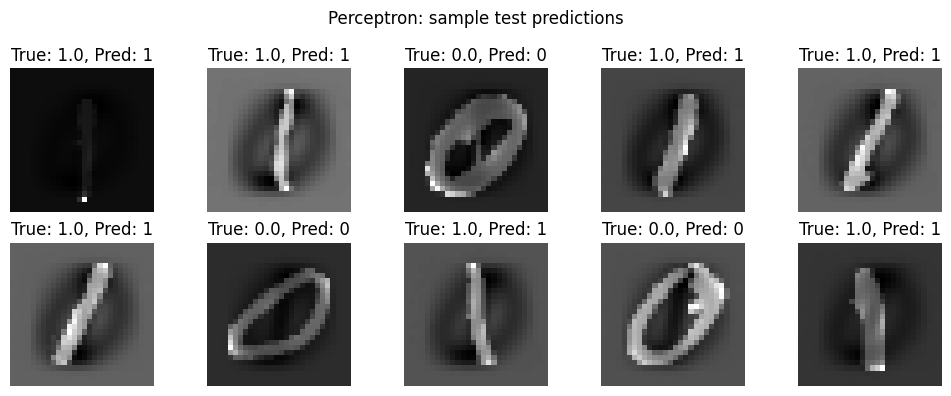

In [6]:
def predict_perceptron(X, W, b):
    out = perceptron_forward(X, W, b)
    return (out >= 0.5).astype(int).flatten()

train_pred = predict_perceptron(X_train, W, b)
test_pred = predict_perceptron(X_test, W, b)
train_acc = np.mean(train_pred == y_train)
test_acc = np.mean(test_pred == y_test)
print(f'Perceptron - Train accuracy: {train_acc:.4f}, Test accuracy: {test_acc:.4f}')

# Show a few sample predictions
fig, axes = plt.subplots(2, 5, figsize=(10, 4))
for i, ax in enumerate(axes.flat):
    idx = i * (len(X_test) // 10)
    ax.imshow(X_test[idx].reshape(28, 28), cmap='gray')
    ax.set_title(f'True: {y_test[idx]}, Pred: {test_pred[idx]}')
    ax.axis('off')
plt.suptitle('Perceptron: sample test predictions')
plt.tight_layout()
plt.show()

The perceptron achieves reasonable accuracy on the binary (0 vs 1) task. It is limited to a **linear** decision boundary in the 784-D space; for harder digit pairs or more classes, we need a non-linear model.

## 4. Part B: Multi-layer neural network (non-linear)

Adding a **hidden layer** with a **non-linear activation (ReLU)** lets the network learn **non-linear** decision boundaries. The model: Input (784) → Hidden (e.g. 64 units, ReLU) → Output (1 unit, sigmoid).

In [7]:
def relu(z):
    return np.maximum(0, z)

def relu_derivative(z):
    return (z > 0).astype(np.float64)

# One hidden layer: 784 -> hidden_size -> 1
hidden_size = 64
np.random.seed(42)
W1 = np.random.randn(input_dim, hidden_size) * 0.1
b1 = np.zeros(hidden_size)
W2 = np.random.randn(hidden_size, 1) * 0.1
b2 = np.zeros(1)

def mlp_forward(X, W1, b1, W2, b2):
    z1 = X @ W1 + b1       # (n, hidden_size)
    a1 = relu(z1)
    z2 = a1 @ W2 + b2      # (n, 1)
    a2 = sigmoid(z2)
    return a2, z1, a1

# Training: backprop for BCE + sigmoid at output, ReLU at hidden
lr_mlp = 0.05
epochs_mlp = 2000
losses = []

for epoch in range(epochs_mlp):
    a2, z1, a1 = mlp_forward(X_train, W1, b1, W2, b2)
    loss = bce_loss(y_train_1d, a2)
    losses.append(loss)
    # Output layer: dL/da2 * da2/dz2 = (a2 - y)/n (for BCE + sigmoid)
    err2 = (a2 - y_train_1d) / n   # (n, 1)
    dW2 = a1.T @ err2               # (hidden_size, 1)
    db2 = np.sum(err2, axis=0)
    err1 = (err2 @ W2.T) * relu_derivative(z1)  # (n, hidden_size)
    dW1 = X_train.T @ err1          # (784, hidden_size)
    db1 = np.sum(err1, axis=0)
    W2 -= lr_mlp * dW2
    b2 -= lr_mlp * db2
    W1 -= lr_mlp * dW1
    b1 -= lr_mlp * db1
    if (epoch + 1) % 400 == 0:
        print(f'Epoch {epoch+1}, Loss: {loss:.4f}')

Epoch 400, Loss: 0.0060
Epoch 800, Loss: 0.0033
Epoch 1200, Loss: 0.0023
Epoch 1600, Loss: 0.0018
Epoch 2000, Loss: 0.0014


MLP - Train accuracy: 0.9997, Test accuracy: 0.9973


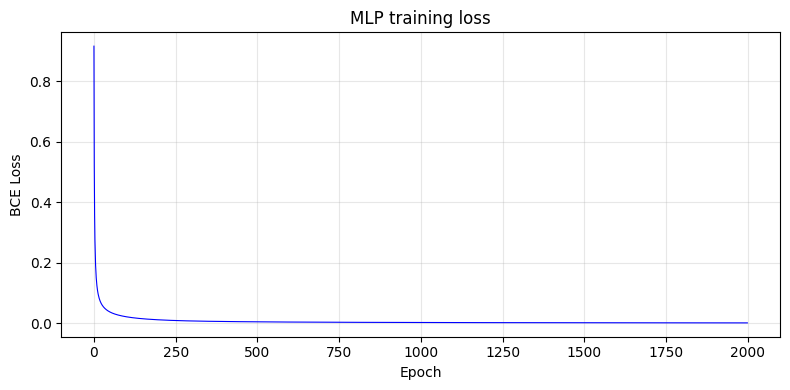

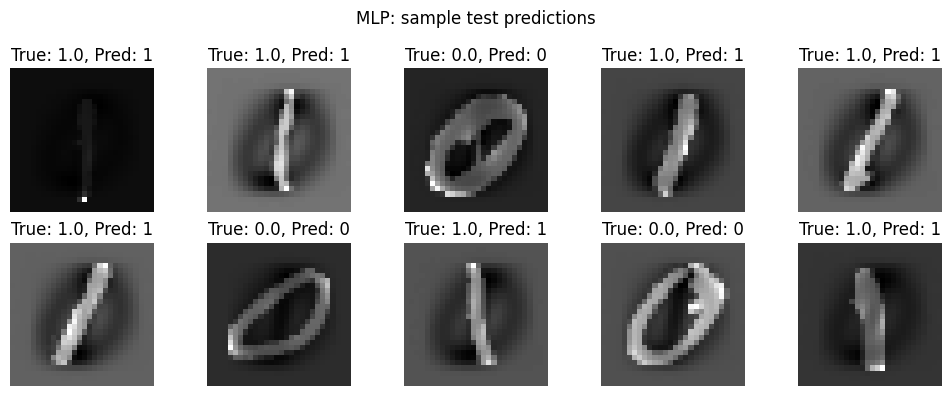

In [8]:
def predict_mlp(X, W1, b1, W2, b2):
    a2, _, _ = mlp_forward(X, W1, b1, W2, b2)
    return (a2 >= 0.5).astype(int).flatten()

train_pred_mlp = predict_mlp(X_train, W1, b1, W2, b2)
test_pred_mlp = predict_mlp(X_test, W1, b1, W2, b2)
train_acc_mlp = np.mean(train_pred_mlp == y_train)
test_acc_mlp = np.mean(test_pred_mlp == y_test)
print(f'MLP - Train accuracy: {train_acc_mlp:.4f}, Test accuracy: {test_acc_mlp:.4f}')

# Plot loss vs epoch
plt.figure(figsize=(8, 4))
plt.plot(losses, color='blue', linewidth=0.8)
plt.xlabel('Epoch')
plt.ylabel('BCE Loss')
plt.title('MLP training loss')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Sample predictions
fig, axes = plt.subplots(2, 5, figsize=(10, 4))
for i, ax in enumerate(axes.flat):
    idx = i * (len(X_test) // 10)
    ax.imshow(X_test[idx].reshape(28, 28), cmap='gray')
    ax.set_title(f'True: {y_test[idx]}, Pred: {test_pred_mlp[idx]}')
    ax.axis('off')
plt.suptitle('MLP: sample test predictions')
plt.tight_layout()
plt.show()

The MLP (with one hidden layer and ReLU) typically achieves similar or better accuracy than the perceptron and can learn a **non-linear** decision boundary, making it more expressive for complex patterns.

## 5. Summary and conclusions

- **Perceptron:** A single-layer (linear) classifier. It learns one hyperplane and works well when the data are (approximately) linearly separable (e.g. digits 0 vs 1).
- **Limitation:** For complex or highly non-linear patterns, a single linear boundary is not enough; the perceptron cannot model curved decision boundaries.
- **MLP:** Adding at least one **hidden layer** and a **non-linear activation (ReLU)** allows the network to learn non-linear decision boundaries and typically improves accuracy on harder tasks.
- **Takeaway:** Linear models (perceptron) are simple and interpretable; for richer patterns we need non-linear models (MLP with hidden layers and activations like ReLU).